<a href="https://colab.research.google.com/github/JasonKilembe/Certificats/blob/master/AR_Selectivity_All_in_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔬 AR Selectivity Dataset — **All-in-One Notebook (ChEMBL + SMILES everywhere)**

This notebook builds an activity dataset for **Androgen Receptor (AR)** and related nuclear receptors (**GR, PR, MR**) from **ChEMBL**, computes pActivity, labels actives/inactives, merges **SMILES** everywhere, and exports `.smi` and optional 3D SDF.


In [2]:

# Install dependencies
!pip -q install chembl_webresource_client pandas tqdm matplotlib rdkit-pypi


In [3]:

from chembl_webresource_client.new_client import new_client
import pandas as pd
import math, os
import matplotlib.pyplot as plt

TARGETS = {"AR":"CHEMBL1871","GR":"CHEMBL2034","PR":"CHEMBL208","MR":"CHEMBL1994"}
STD_TYPES   = {"IC50","Ki","EC50"}
ASSAY_TYPES = {"B"}
ACTIVE_TH, INACT_TH = 6.0, 5.0
OUTDIR = "dataset_AR_selectivity"


In [6]:
def _to_p_activity(row):
    p = row.get("pchembl_value")
    if p is not None:
        try: return float(p)
        except: pass
    val = row.get("standard_value")
    units = (row.get("standard_units") or "").lower()
    if val is None or units != "nm": return None
    try:
        val = float(val)
        if val <= 0: return None
        return -math.log10(val*1e-9)
    except: return None

def _label_from_p(p):
    if p is None or (isinstance(p, float) and pd.isna(p)): return -1
    if p >= ACTIVE_TH: return 1
    if p <= INACT_TH:  return 0
    return -1

def fetch_activities_for_target(tid):
    act = new_client.activity.filter(
        target_chembl_id=tid,
        assay_type__in=list(ASSAY_TYPES),
        standard_value__isnull=False
    ).only(["molecule_chembl_id","target_chembl_id","assay_type","standard_type",
            "standard_relation","standard_value","standard_units","pchembl_value","activity_comment"])
    df = pd.DataFrame(act)
    if df.empty: return df
    df = df[df["standard_type"].isin(STD_TYPES)]
    df = df[(df["standard_relation"].isna()) | (df["standard_relation"]=="=")]
    df["pActivity"] = df.apply(_to_p_activity, axis=1)
    df = df.dropna(subset=["pActivity"])
    return df

def best_per_ligand_target(df):
    idx = df.groupby(["molecule_chembl_id","target_chembl_id"])["pActivity"].idxmax()
    return df.loc[idx].reset_index(drop=True)

def fetch_smiles(chembl_ids, chunk=1000, try_fix_from_inchi=True):
    ids = pd.unique(pd.Series(chembl_ids).dropna().astype(str)).tolist()
    frames = []
    for i in range(0, len(ids), chunk):
        sub = ids[i:i+chunk]
        mols = new_client.molecule.filter(
            molecule_chembl_id__in=sub
        ).only(["molecule_chembl_id","molecule_structures","molecule_properties","pref_name"])
        mdf = pd.DataFrame(mols)
        if mdf.empty:
            continue
        if "molecule_structures" in mdf.columns:
            ms = mdf["molecule_structures"]
            mdf["canonical_smiles"] = ms.apply(lambda d: d.get("canonical_smiles") if isinstance(d, dict) else None)
            mdf["inchi_key"]        = ms.apply(lambda d: d.get("standard_inchi_key") if isinstance(d, dict) else None)
            mdf["standard_inchi"]   = ms.apply(lambda d: d.get("standard_inchi") if isinstance(d, dict) else None)
        else:
            mdf["canonical_smiles"] = None
            mdf["inchi_key"] = None
            mdf["standard_inchi"] = None
        mdf = mdf.rename(columns={"molecule_chembl_id":"chembl_id"})
        frames.append(mdf[["chembl_id","canonical_smiles","inchi_key","standard_inchi","pref_name"]])
    out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
        columns=["chembl_id","canonical_smiles","inchi_key","standard_inchi","pref_name"]
    )
    if try_fix_from_inchi and not out.empty:
        try:
            from rdkit import Chem
            from rdkit.Chem import inchi
            mask = out["canonical_smiles"].isna() & out["standard_inchi"].notna()
            if mask.any():
                for idx, row in out.loc[mask].iterrows():
                    try:
                        mol = inchi.MolFromInchi(row["standard_inchi"])
                        if mol:
                            out.at[idx, "canonical_smiles"] = Chem.MolToSmiles(mol)
                    except Exception:
                        pass
        except Exception:
            pass
    out = out.drop(columns=["standard_inchi"], errors="ignore").drop_duplicates(subset=["chembl_id"])
    return out

In [8]:

def fetch_smiles(chembl_ids, chunk=1000, try_fix_from_inchi=True):
    ids = pd.unique(pd.Series(chembl_ids).dropna().astype(str)).tolist()
    frames = []
    for i in range(0, len(ids), chunk):
        sub = ids[i:i+chunk]
        mols = new_client.molecule.filter(
            molecule_chembl_id__in=sub
        ).only(["molecule_chembl_id","molecule_structures","molecule_properties","pref_name"])
        mdf = pd.DataFrame(mols)
        if mdf.empty:
            continue
        if "molecule_structures" in mdf.columns:
            ms = mdf["molecule_structures"]
            mdf["canonical_smiles"] = ms.apply(lambda d: d.get("canonical_smiles") if isinstance(d, dict) else None)
            mdf["inchi_key"]        = ms.apply(lambda d: d.get("standard_inchi_key") if isinstance(d, dict) else None)
            mdf["standard_inchi"]   = ms.apply(lambda d: d.get("standard_inchi") if isinstance(d, dict) else None)
        else:
            mdf["canonical_smiles"] = None
            mdf["inchi_key"] = None
            mdf["standard_inchi"] = None
        mdf = mdf.rename(columns={"molecule_chembl_id":"chembl_id"})
        frames.append(mdf[["chembl_id","canonical_smiles","inchi_key","standard_inchi","pref_name"]])
    out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
        columns=["chembl_id","canonical_smiles","inchi_key","standard_inchi","pref_name"]
    )
    if try_fix_from_inchi and not out.empty:
        try:
            from rdkit import Chem
            from rdkit.Chem import inchi
            mask = out["canonical_smiles"].isna() & out["standard_inchi"].notna()
            if mask.any():
                for idx, row in out.loc[mask].iterrows():
                    try:
                        mol = inchi.MolFromInchi(row["standard_inchi"])
                        if mol:
                            out.at[idx, "canonical_smiles"] = Chem.MolToSmiles(mol)
                    except Exception:
                        pass
        except Exception:
            pass
    out = out.drop(columns=["standard_inchi"], errors="ignore").drop_duplicates(subset=["chembl_id"])
    return out


In [9]:
# RUN PIPELINE
os.makedirs(OUTDIR, exist_ok=True)

all_raw = []
print("Fetching activities from ChEMBL …")
for name, tid in TARGETS.items():
    print(f"  - {name} ({tid})")
    d = fetch_activities_for_target(tid)
    if d.empty:
        print(f"    ! No activities found for {name}")
        continue
    d["target_short"] = name
    all_raw.append(d)

if not all_raw:
    raise SystemExit("No activities retrieved.")

raw = pd.concat(all_raw, ignore_index=True).copy()
raw["molecule_chembl_id"] = raw["molecule_chembl_id"].astype(str)
raw["target_chembl_id"]   = raw["target_chembl_id"].astype(str)

# Merge SMILES (avoid duplicate 'chembl_id')
smiles_map = fetch_smiles(raw["molecule_chembl_id"].unique()).rename(columns={"chembl_id":"chembl_id_smiles"})
raw_smiles = raw.merge(smiles_map, left_on="molecule_chembl_id", right_on="chembl_id_smiles", how="left")

# Diagnostics
coverage = (raw_smiles["canonical_smiles"].notna()).mean()
print(f"SMILES coverage in RAW: {coverage:.1%}")

missing = raw_smiles[raw_smiles["canonical_smiles"].isna()][["molecule_chembl_id"]].drop_duplicates()
if not missing.empty:
    missing.to_csv(os.path.join(OUTDIR, "missing_smiles.csv"), index=False)
    print(f"⚠️  {len(missing)} ligands have no SMILES -> {os.path.join(OUTDIR,'missing_smiles.csv')}")

# Save RAW
cols_raw = ["molecule_chembl_id","target_chembl_id","target_short","assay_type",
            "standard_type","standard_relation","standard_value","standard_units",
            "pchembl_value","pActivity","canonical_smiles","inchi_key","pref_name"]
raw_smiles.loc[:, cols_raw].to_csv(os.path.join(OUTDIR,"chembl_selectivity_raw.csv"), index=False)
print("✔ RAW written")

# LONG
best = best_per_ligand_target(raw_smiles)
best["label"] = best["pActivity"].apply(_label_from_p)
best = best.rename(columns={"molecule_chembl_id":"chembl_id","target_chembl_id":"target_id"})
best = best.drop(columns=["chembl_id_smiles"], errors="ignore")
best = best.loc[:, ~best.columns.duplicated()]
best = best[["chembl_id","canonical_smiles","inchi_key","pref_name","target_id","target_short","standard_type","pActivity","label"]]
best = (best.sort_values(["chembl_id","target_short","pActivity"], ascending=[True,True,False])
            .drop_duplicates(subset=["chembl_id","target_short"], keep="first"))
best.to_csv(os.path.join(OUTDIR,"chembl_selectivity_long.csv"), index=False)
print("✔ LONG written")

# WIDE
index_cols = ["chembl_id","canonical_smiles","inchi_key","pref_name"]
wide_p = best.pivot_table(index=index_cols, columns="target_short", values="pActivity", aggfunc="max")
wide_l = best.pivot_table(index=index_cols, columns="target_short", values="label",     aggfunc="max")
wide_p.columns = [f"pAct_{c}" for c in wide_p.columns]
wide_l.columns = [f"label_{c}" for c in wide_l.columns]
wide = pd.concat([wide_p, wide_l], axis=1).reset_index()
cols = ["chembl_id","pref_name","canonical_smiles","inchi_key","pAct_AR","pAct_GR","pAct_PR","pAct_MR",
        "label_AR","label_GR","label_PR","label_MR"]
for c in cols:
    if c not in wide.columns: wide[c] = pd.NA
wide = wide[cols]
wide.to_csv(os.path.join(OUTDIR,"chembl_selectivity_wide.csv"), index=False)
print("✔ WIDE written")

# SMI
smi = wide[["canonical_smiles","chembl_id"]].dropna().drop_duplicates()
smi.to_csv(os.path.join(OUTDIR,"ligands_unique.smi"), sep="\t", header=False, index=False)
print(f"✔ SMI written (unique ligands={len(smi)})")

Fetching activities from ChEMBL …
  - AR (CHEMBL1871)
  - GR (CHEMBL2034)
  - PR (CHEMBL208)
  - MR (CHEMBL1994)
SMILES coverage in RAW: 100.0%
⚠️  2 ligands have no SMILES -> dataset_AR_selectivity/missing_smiles.csv
✔ RAW written
✔ LONG written
✔ WIDE written
✔ SMI written (unique ligands=148)


In [1]:
!pip install "numpy<2.0" "pandas<2.2"
!pip install "rdkit-pypi==2022.9.5"

In [10]:

# Optional: export 3D SDF from SMILES
from rdkit import Chem
from rdkit.Chem import AllChem

smi_path = os.path.join(OUTDIR, "ligands_unique.smi")
sdf_path = os.path.join(OUTDIR, "ligands_unique_3D.sdf")

if os.path.exists(smi_path):
    suppl = []
    with open(smi_path, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            smi, chembl_id = parts
            m = Chem.MolFromSmiles(smi)
            if m is None:
                continue
            m = Chem.AddHs(m)
            ok = AllChem.EmbedMolecule(m, AllChem.ETKDGv3())
            if ok == 0:
                AllChem.UFFOptimizeMolecule(m, maxIters=200)
            m.SetProp("_Name", chembl_id)
            suppl.append(m)
    if suppl:
        w = Chem.SDWriter(sdf_path)
        for m in suppl:
            w.write(m)
        w.close()
        print(f"✔ SDF written to {sdf_path} (mols={len(suppl)})")
    else:
        print("No molecules to write to SDF.")
else:
    print("SMI not found; skip SDF export.")


[19:13:09] UFFTYPER: Unrecognized charge state for atom: 23
[19:13:10] UFFTYPER: Unrecognized charge state for atom: 23


✔ SDF written to dataset_AR_selectivity/ligands_unique_3D.sdf (mols=148)


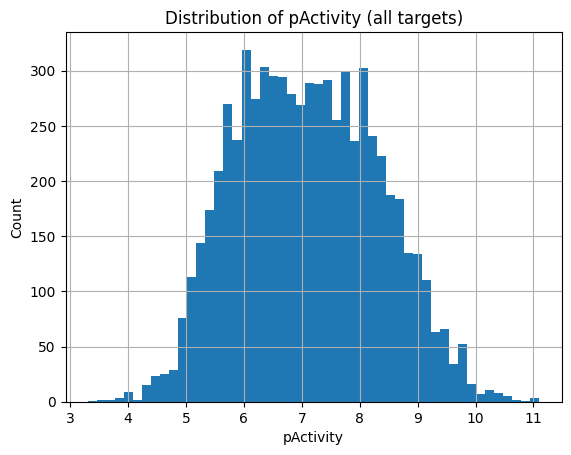

<Figure size 640x480 with 0 Axes>

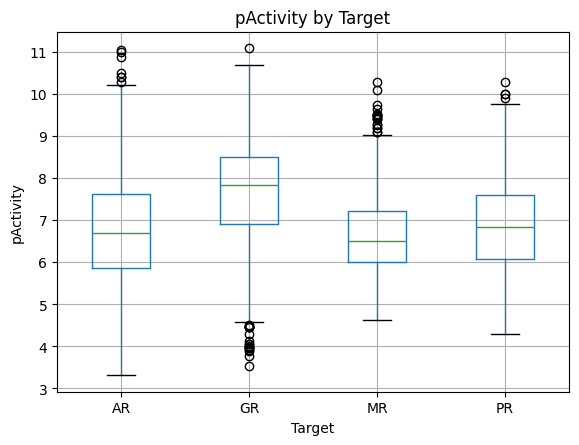

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

long = pd.read_csv("/content/dataset_AR_selectivity/chembl_selectivity_long.csv")

plt.figure()
long["pActivity"].hist(bins=50)
plt.title("Distribution of pActivity (all targets)")
plt.xlabel("pActivity")
plt.ylabel("Count")
plt.show()

plt.figure()
long.boxplot(column="pActivity", by="target_short")
plt.title("pActivity by Target")
plt.suptitle("")
plt.xlabel("Target")
plt.ylabel("pActivity")
plt.show()
